# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt


# Load Datasets

User Data

In [2]:
user_df = pd.read_csv('/content/drive/MyDrive/user_dataset_new.csv')

# Display the first few rows of the dataset
print(user_df.head())

               email  user_id  age  gender ratings  reviews_music  \
0  user1@example.com        1   56    male    best              5   
1  user2@example.com        2   69  female     bad              3   
2  user3@example.com        3   46  female     bad              4   
3  user4@example.com        4   32  female   worst              3   
4  user5@example.com        5   60    male    good              1   

   reviews_business  reviews_food  reviews_art  reviews_films  reviews_sports  \
0                 3             2            2              4               4   
1                 2             3            3              5               4   
2                 4             5            2              1               3   
3                 1             1            5              2               1   
4                 5             2            4              2               5   

      location favorite  
0      Colombo      yes  
1      Negombo      yes  
2        Galle      

Event Data

In [3]:
event_df = pd.read_csv('/content/drive/MyDrive/event_dataset_new.csv')

# Display the first few rows of the dataset
print(event_df.head())

   event_id event_category location  reviews
0         1           food  Colombo        3
1         2          films   Matara        2
2         3       business   Jaffna        4
3         4       business    Galle        5
4         5          films  Negombo        3


# Data Preprocessing

Handle Null Values

In [4]:
# Check and handle null values
user_df.fillna(user_df.mode().iloc[0], inplace=True)
event_df.fillna(event_df.mode().iloc[0], inplace=True)


Handle Duplicate Values

In [5]:
# Remove duplicate values
user_df.drop_duplicates(inplace=True)
event_df.drop_duplicates(inplace=True)


Encode Categorical Variables

In [6]:
# Encoding categorical features
le_gender = LabelEncoder()
user_df['gender_encoded'] = le_gender.fit_transform(user_df['gender'])

le_ratings = LabelEncoder()
user_df['ratings_encoded'] = le_ratings.fit_transform(user_df['ratings'])

user_df['favorite_encoded'] = user_df['favorite'].map({'yes': 1, 'no': 0})

le_event_category = LabelEncoder()
event_df['event_category_encoded'] = le_event_category.fit_transform(event_df['event_category'])


# Create User-Event Interaction Matrix

In [7]:
# Create user-event interaction matrix based on user location and favorite events
user_event_matrix = user_df.pivot_table(
    index='user_id',
    columns='location',
    values='favorite_encoded',
    fill_value=0
)


# Compute Cosine Similarity

In [8]:
# Compute cosine similarity between users
user_similarity = cosine_similarity(user_event_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_event_matrix.index, columns=user_event_matrix.index)


# Content-Based Filtering

In [9]:
# Function to recommend events based on content
def recommend_events_content(user_id, user_df, event_df):
    user_info = user_df[user_df['user_id'] == user_id].iloc[0]
    location = user_info['location']
    similar_events = event_df[event_df['location'] == location]
    return similar_events['event_id'].tolist()


# Collaborative Filtering

In [10]:
# Function to recommend events based on collaborative filtering
def recommend_events_collaborative(user_id, user_similarity_df, user_event_matrix, num_recommendations=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:]
    recommended_events = []

    for similar_user in similar_users:
        events = user_event_matrix.loc[similar_user].where(lambda x: x > 0).dropna().index.tolist()
        recommended_events.extend(events)

    attended_events = user_event_matrix.loc[user_id].where(lambda x: x > 0).dropna().index.tolist()
    recommended_events = [event for event in recommended_events if event not in attended_events]

    return list(set(recommended_events))[:num_recommendations]


# Hybrid Recommendation System

In [11]:
# Function to combine content-based and collaborative filtering
def hybrid_recommendation(user_id, user_df, event_df, user_similarity_df, user_event_matrix):
    content_recommendations = recommend_events_content(user_id, user_df, event_df)
    collaborative_recommendations = recommend_events_collaborative(user_id, user_similarity_df, user_event_matrix)

    # Combine and deduplicate recommendations
    combined_recommendations = list(set(content_recommendations + collaborative_recommendations))
    return combined_recommendations

#  As Example Recommend events for a specific user
user_id = 1  # Example user ID
recommendations = hybrid_recommendation(user_id, user_df, event_df, user_similarity_df, user_event_matrix)
print(f"Recommended events for user {user_id}: {recommendations}")


Recommended events for user 1: [1, 4097, 6148, 7, 9, 6153, 11, 2060, 13, 4110, 15, 4112, 4115, 2068, 4118, 8216, 4122, 2076, 6175, 32, 4131, 8227, 4133, 2089, 2090, 4137, 6186, 6188, 48, 6193, 2099, 4147, 4148, 8246, 2105, 6201, 62, 6207, 67, 68, 6213, 8259, 6216, 74, 8268, 4174, 8272, 2129, 6225, 86, 6230, 6234, 6238, 98, 2147, 100, 4201, 4203, 8299, 8301, 8302, 6255, 8304, 8306, 4213, 8310, 119, 122, 2170, 8314, 6269, 126, 6270, 2176, 2179, 8324, 8329, 8330, 4235, 2188, 6286, 8334, 4240, 8336, 2194, 147, 8337, 8340, 8345, 4250, 8348, 6301, 6302, 8349, 4261, 4263, 2216, 169, 2217, 4264, 172, 2221, 6317, 8359, 6320, 8360, 178, 179, 180, 4277, 4278, 8368, 'Kandy', 185, 187, 2235, 2236, 2237, 8379, 8382, 8385, 2242, 6339, 2244, 2246, 199, 4297, 6349, 4306, 2259, 2261, 214, 6357, 216, 2264, 2265, 8405, 220, 6365, 2271, 4320, 2274, 2275, 6371, 4325, 8418, 8422, 232, 2282, 236, 6381, 8433, 244, 8436, 246, 2295, 6391, 2301, 255, 4353, 2306, 2310, 6409, 8458, 2316, 8461, 4366, 8463, 6416, 436

# Data Visualization

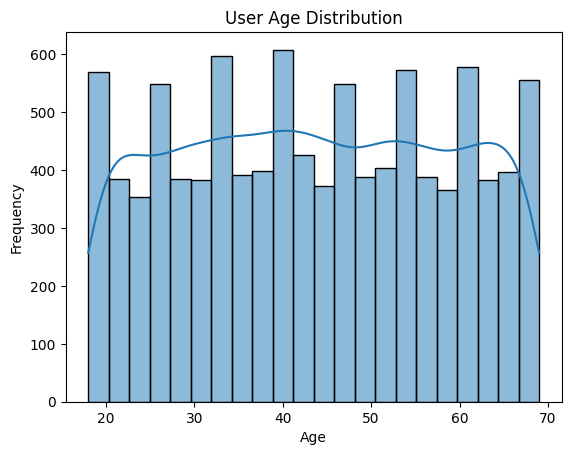

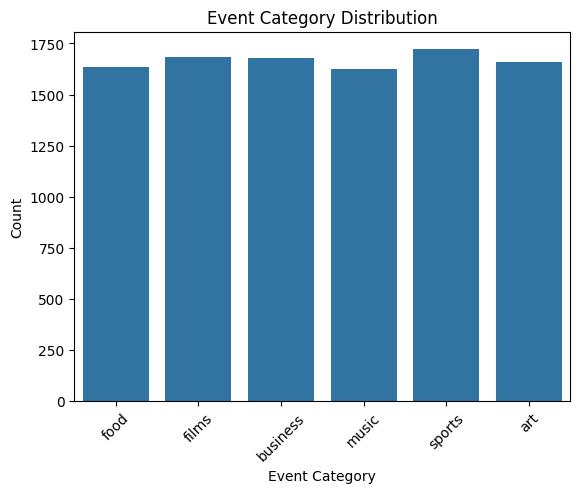

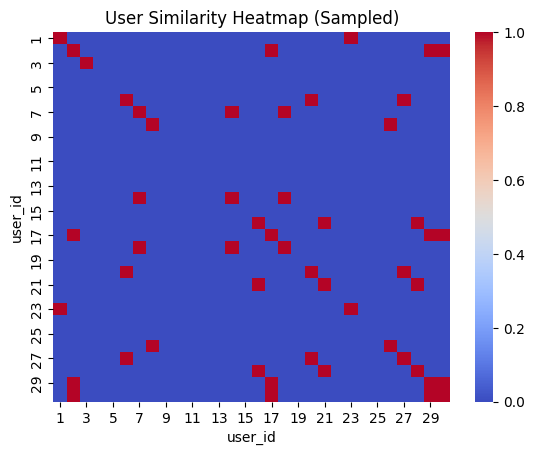

In [12]:
# User Age Distribution
sns.histplot(user_df['age'], kde=True)
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Event Category Distribution
sns.countplot(data=event_df, x='event_category')
plt.title('Event Category Distribution')
plt.xlabel('Event Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Heatmap of User Similarity Matrix (sampled)
sns.heatmap(user_similarity_df.iloc[:30, :30], cmap='coolwarm')
plt.title('User Similarity Heatmap (Sampled)')
plt.show()
